<h1> Initialize NEST and solve for LY, QY at all energies vs. Electric field</h1>

In [36]:
from __future__ import division
import sys
home_dir=!echo "$HOME"
sys.path.insert(2,home_dir[0]+'/iPyNb/NERSC_Import') #make sure you have iPyNb checked out from AD
sys.path.insert(2,home_dir[0]+'/LZ_git/fastNEST/libNEST') #add to import Lib-NEST
import libNEST
from pyROOT_import import *
from ROOT import TH2D, TFile, TBranch
import pandas as pd
import scipy.interpolate as ip
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 18})

Populating the interactive namespace from numpy and matplotlib


<h1> Calculate LY QY for ER at 100 V/cm as a test</h1>

In [3]:
NEST=libNEST.NEST(1,10,100,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LZSettings()
NEST.SetDetectorParameters(myDet)

LY=[]
QY=[]
Energy = logspace(-1,log10(5000),100)

for En in Energy:
    NEST.SetEnergy(En)
    LY_step=[]
    QY_step=[]
    for ii in arange(0,10000,1):
        NEST.DetectorResponse()
        LY_step.append(NEST.GetNumPhotons())
        QY_step.append(NEST.GetNumElectrons())
    LY.append(mean(np.array(LY_step))/En)
    QY.append(mean(np.array(QY_step))/En)

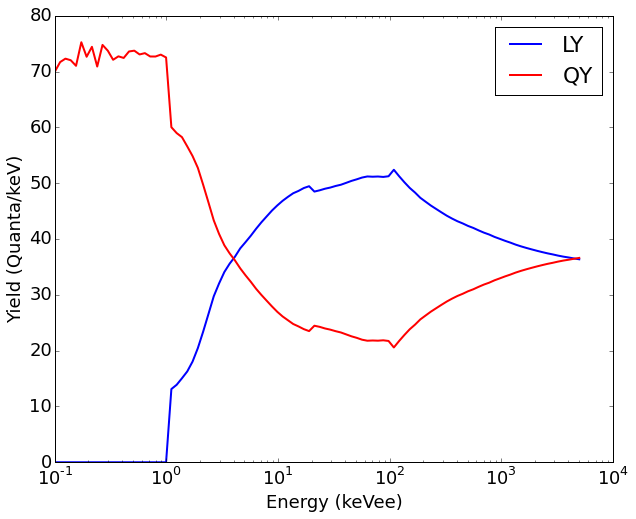

In [4]:
## semilogx(Energy,LY,linewidth=2)
semilogx(Energy,LY,'-b',linewidth=2)
semilogx(Energy,QY,'-r',linewidth=2)
xlabel('Energy (keVee)')
ylabel('Yield (Quanta/keV)')
legend(['LY','QY'])

<h1> Calculate LY QY for NR at 100 V/cm as a test</h1>

In [5]:
NEST=libNEST.NEST(0,10,100,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LZSettings()
NEST.SetDetectorParameters(myDet)

LY=[]
QY=[]
Energy = logspace(-1,log10(300),100)

for En in Energy:
    NEST.SetEnergy(En)
    LY_step=[]
    QY_step=[]
    for ii in arange(0,10000,1):
        NEST.DetectorResponse()
        LY_step.append(NEST.GetNumPhotons())
        QY_step.append(NEST.GetNumElectrons())
    LY.append(mean(np.array(LY_step))/En)
    QY.append(mean(np.array(QY_step))/En)

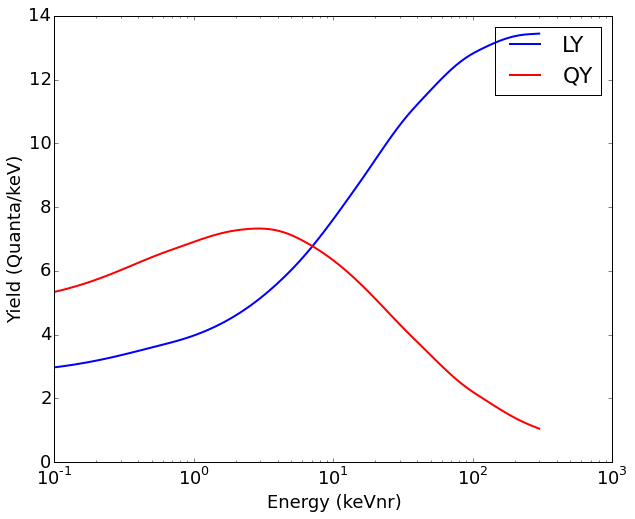

In [8]:
## semilogx(Energy,LY,linewidth=2)

#Smooth out the curve, save some compuational power
sLY = ip.UnivariateSpline(Energy, LY,s=0.1)
sQY = ip.UnivariateSpline(Energy, QY,s=0.1)

semilogx(Energy,sLY(Energy),'-b',linewidth=2)
semilogx(Energy,sQY(Energy),'-r',linewidth=2)
#semilogx(Energy,LY,'-b',linewidth=2)
#semilogx(Energy,QY,'-r',linewidth=2)
xlabel('Energy (keVnr)')
ylabel('Yield (Quanta/keV)')
legend(['LY','QY'])

<h1> Calculate ER yields at multiple fields. Plot and save </h1>

In [9]:
NEST=libNEST.NEST(1,10,100,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LZSettings()
NEST.SetDetectorParameters(myDet)

LY_list=[]
QY_list=[]
Energy = logspace(-1,log10(5000),100)
Efield=array([0,50,100,200,500,1000,2000])

for Ef in Efield:
    NEST.SetElectricField(Ef)
    LY=[]
    QY=[]
    for En in Energy:
        NEST.SetEnergy(En)
        LY_step=[]
        QY_step=[]
        for ii in arange(0,100000,1):
            NEST.DetectorResponse()
            LY_step.append(NEST.GetNumPhotons())
            QY_step.append(NEST.GetNumElectrons())
        LY.append(mean(np.array(LY_step))/En)
        QY.append(mean(np.array(QY_step))/En)
    LY_list.append(LY)
    QY_list.append(QY)

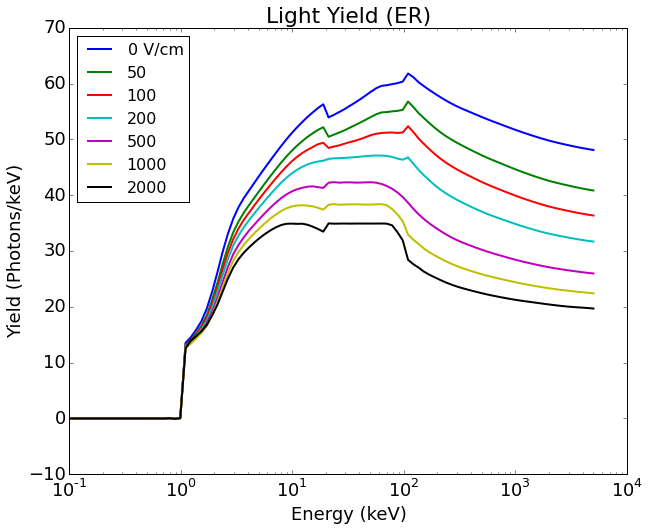

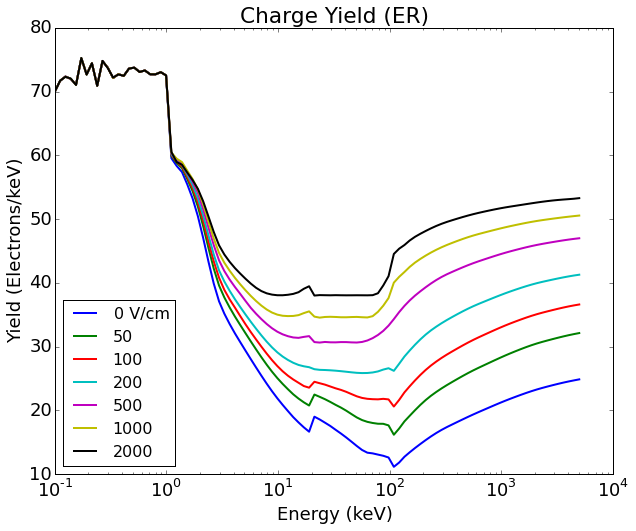

In [10]:
legend_text=[]
for ii, Ef in enumerate(Efield):
    sLY = ip.UnivariateSpline(Energy, LY_list[ii],s=.05)
    semilogx(Energy,sLY(Energy),linewidth=2)
    #semilogx(Energy,LY_list[ii],linewidth=2)
    if ii==0:
        legend_text.append(str(Ef)+' V/cm')
    else:
        legend_text.append(str(Ef))
title('Light Yield (ER)')
xlabel('Energy (keV)')
ylabel('Yield (Photons/keV)')
legend(legend_text,fontsize=16,loc='upper left')
plt.savefig('val_figs/LY_ER_Fields.png')

figure()
legend_text=[]
for ii, Ef in enumerate(Efield):
    sQY = ip.UnivariateSpline(Energy, QY_list[ii],s=.05)
    semilogx(Energy,sQY(Energy),linewidth=2)
    #semilogx(Energy,QY_list[ii],linewidth=2)
    if ii==0:
        legend_text.append(str(Ef)+' V/cm')
    else:
        legend_text.append(str(Ef))
title('Charge Yield (ER)')
xlabel('Energy (keV)')
ylabel('Yield (Electrons/keV)')
legend(legend_text,fontsize=16,loc='lower left')
plt.savefig('val_figs/QY_ER_Fields.png')


<h1> Save data to mat and root </h1>

In [11]:
Y_ER=dict([('Energy',Energy)])
for ii, Ef in enumerate(Efield):
    Y_ER.update([('LY-'+str(Ef)+'-Vcm',LY_list[ii])])
    Y_ER.update([('QY-'+str(Ef)+'-Vcm',QY_list[ii])])
#save mat
sio.savemat('NEST_Yields/ER_Yields_TDR',Y_ER)

#Write root file ... ROOT is just the worst, you have to fill element by element
f = TFile('NEST_Yields/ER_Yields_TDR.root', "recreate") 
t = TTree("tree", "ER Yields")
n=[]
vals=[]
for ii,(key,val) in enumerate(Y_ER.iteritems()):
    vals.append(val)
    n.append(np.array([0],dtype=float64))
    t.Branch(key, n[ii], key+'/d') #d is float64
#for kk, v in enumerate(val):

for jj in range(size(val)):
    for kk in range(ii):
        n[kk][0] =vals[kk][jj]
    t.Fill()

f.Write()
f.Close()

#load in data:
#matarr=sio.loadmat('NEST_Yields/ER_Yields_TDR.mat')
#rootarr=root2array('NEST_Yields/ER_Yields_TDR.root', treename='tree')

<h1> Calculate NR at multiple fields </h1>

# NEST=libNEST.NEST(0,10,100,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LZSettings()
NEST.SetDetectorParameters(myDet)

LY_list_nr=[]
QY_list_nr=[]
Energy = logspace(-1,log10(300),100)
Efield=array([0,50,100,200,500,1000,2000])

for Ef in Efield:
    NEST.SetElectricField(Ef)
    LY=[]
    QY=[]
    for En in Energy:
        NEST.SetEnergy(En)
        LY_step=[]
        QY_step=[]
        for ii in arange(0,100000,1):
            NEST.DetectorResponse()
            LY_step.append(NEST.GetNumPhotons())
            QY_step.append(NEST.GetNumElectrons())
        LY.append(mean(np.array(LY_step))/En)
        QY.append(mean(np.array(QY_step))/En)
    LY_list_nr.append(LY)
    QY_list_nr.append(QY)

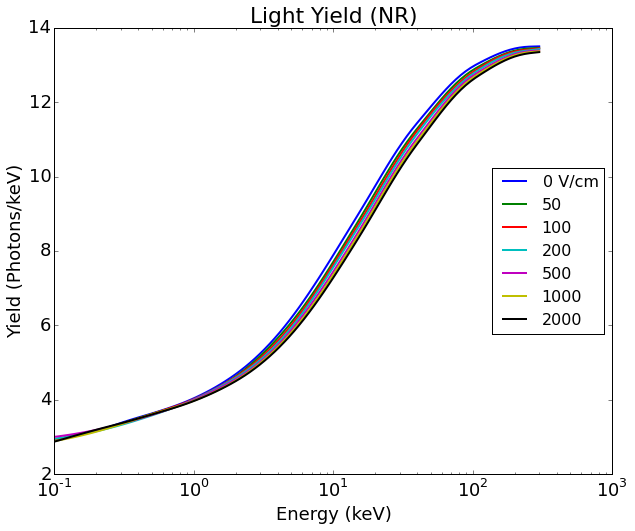

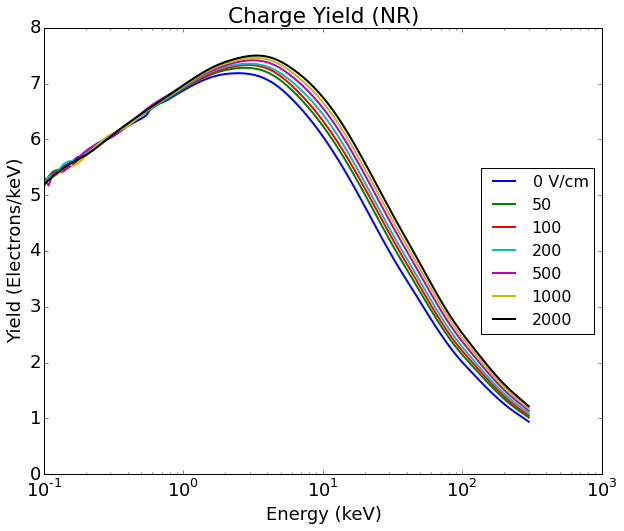

In [23]:
legend_text=[]
for ii, Ef in enumerate(Efield):
    sLY = ip.UnivariateSpline(Energy, LY_list_nr[ii],s=.05)
    semilogx(Energy,sLY(Energy),linewidth=2)
    #semilogx(Energy,LY_list_nr[ii],linewidth=2)
    if ii==0:
        legend_text.append(str(Ef)+' V/cm')
    else:
        legend_text.append(str(Ef))
title('Light Yield (NR)')
xlabel('Energy (keV)')
ylabel('Yield (Photons/keV)')
legend(legend_text,fontsize=16,loc='right')
#xlim([0.1,10])
#ylim([2,5])
#plt.savefig('val_figs/LY_NR_Fields.png')

figure()
legend_text=[]
for ii, Ef in enumerate(Efield):
    sQY = ip.UnivariateSpline(Energy, QY_list_nr[ii],s=.05)
    semilogx(Energy,sQY(Energy),linewidth=2)
    #semilogx(Energy,QY_list_nr[ii],'-',linewidth=2)
    if ii==0:
        legend_text.append(str(Ef)+' V/cm')
    else:
        legend_text.append(str(Ef))
title('Charge Yield (NR)')
xlabel('Energy (keV)')
ylabel('Yield (Electrons/keV)')
#xlim([0.1,10])
legend(legend_text,fontsize=16,loc='right')
#plt.savefig('val_figs/QY_NR_Fields.png')

<h1> Save data to mat and root </h1>

In [14]:
Y_NR=dict([('Energy',Energy)])
for ii, Ef in enumerate(Efield):
    Y_NR.update([('LY-'+str(Ef)+'-Vcm',LY_list_nr[ii])])
    Y_NR.update([('QY-'+str(Ef)+'-Vcm',QY_list_nr[ii])])
#save mat
sio.savemat('NEST_Yields/NR_Yields_TDR',Y_NR)

#Write root file ... ROOT is just the worst, you have to fill element by element
f = TFile('NEST_Yields/NR_Yields_TDR.root', "recreate") 
t = TTree("tree", "NR Yields")
n=[]
vals=[]
for ii,(key,val) in enumerate(Y_NR.iteritems()):
    vals.append(val)
    n.append(np.array([0],dtype=float64))
    t.Branch(key, n[ii], key+'/d') #d is float64
#for kk, v in enumerate(val):

for jj in range(size(val)):
    for kk in range(ii):
        n[kk][0] =vals[kk][jj]
    t.Fill()

f.Write()
f.Close()

#load in data:
#matarr=sio.loadmat('NEST_Yields/ER_Yields_TDR.mat')
#rootarr=root2array('NEST_Yields/ER_Yields_TDR.root', treename='tree')

<h1> Display LY QY results for ER and NR in pd dataframe </h1>

In [15]:
cols=np.array(['Energy',
 'LY-0-Vcm',
 'QY-0-Vcm',
 'LY-50-Vcm',
 'QY-50-Vcm',
 'LY-100-Vcm',
 'QY-100-Vcm',
 'LY-200-Vcm',
 'QY-200-Vcm',
 'LY-500-Vcm',
 'QY-500-Vcm',
 'LY-1000-Vcm',
 'QY-1000-Vcm',
 'LY-2000-Vcm',
 'QY-2000-Vcm',
 ])

<h1> Print ER results </h1>

In [16]:
pd.set_option('display.max_rows', 100)  
ER_df=pd.DataFrame(Y_ER)
#display LY-ER
ER_df[cols[[0]+range(1,15,2)]]

,Energy,LY-0-Vcm,LY-50-Vcm,LY-100-Vcm,LY-200-Vcm,LY-500-Vcm,LY-1000-Vcm,LY-2000-Vcm
0,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.111549,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.124431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.138801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.154831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.172712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.192658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.214907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.239726,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.267411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
#display QY-NR
ER_df[cols[[0]+range(2,15,2)]]

,Energy,QY-0-Vcm,QY-50-Vcm,QY-100-Vcm,QY-200-Vcm,QY-500-Vcm,QY-1000-Vcm,QY-2000-Vcm
0,0.100000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
1,0.111549,71.717583,71.717583,71.717583,71.717583,71.717583,71.717583,71.717583
2,0.124431,72.329227,72.329227,72.329227,72.329227,72.329227,72.329227,72.329227
3,0.138801,72.045518,72.045518,72.045518,72.045518,72.045518,72.045518,72.045518
4,0.154831,71.045293,71.045293,71.045293,71.045293,71.045293,71.045293,71.045293
5,0.172712,75.269951,75.269951,75.269951,75.269951,75.269951,75.269951,75.269951
6,0.192658,72.667794,72.667794,72.667794,72.667794,72.667794,72.667794,72.667794
7,0.214907,74.450836,74.450836,74.450836,74.450836,74.450836,74.450836,74.450836
8,0.239726,70.914358,70.914358,70.914358,70.914358,70.914358,70.914358,70.914358
9,0.267411,74.791269,74.791269,74.791269,74.791269,74.791269,74.791269,74.791269


<h1> Print NR resuts </h1>

In [18]:
pd.set_option('display.max_rows', 100)  
NR_df=pd.DataFrame(Y_NR)
#display LY-NR
NR_df[cols[[0]+range(1,15,2)]]

,Energy,LY-0-Vcm,LY-50-Vcm,LY-100-Vcm,LY-200-Vcm,LY-500-Vcm,LY-1000-Vcm,LY-2000-Vcm
0,0.100000,2.913000,2.893000,2.928300,2.910200,2.902700,2.928900,2.900800
1,0.108423,2.946416,2.966983,2.904451,2.929353,2.923358,2.922159,2.954717
2,0.117556,2.988873,2.943788,2.950338,2.935962,2.961737,2.965480,2.972625
3,0.127458,3.006636,3.009539,3.001301,3.016757,3.008205,2.977528,3.014874
4,0.138194,3.045714,3.025164,3.021907,3.028348,3.060838,3.038985,3.019664
5,0.149835,3.071853,3.059039,3.060241,3.052966,3.061375,3.065780,3.059239
6,0.162456,3.107311,3.097524,3.114390,3.113774,3.088660,3.074379,3.078134
7,0.176140,3.131323,3.130925,3.148184,3.175038,3.097259,3.119741,3.122636
8,0.190976,3.164686,3.167775,3.199664,3.183641,3.156884,3.159240,3.157617
9,0.207063,3.194008,3.216223,3.233561,3.185991,3.201252,3.206806,3.185170


In [19]:
#display QY-NR
NR_df[cols[[0]+range(2,15,2)]]

,Energy,QY-0-Vcm,QY-50-Vcm,QY-100-Vcm,QY-200-Vcm,QY-500-Vcm,QY-1000-Vcm,QY-2000-Vcm
0,0.100000,5.263600,5.261800,5.237500,5.254900,5.234000,5.234500,5.204000
1,0.108423,5.305135,5.286228,5.327547,5.265660,5.308824,5.326440,5.302460
2,0.117556,5.353192,5.349875,5.345962,5.361869,5.362465,5.370631,5.347748
3,0.127458,5.392440,5.447910,5.437004,5.418331,5.400051,5.447831,5.417154
4,0.138194,5.453414,5.509277,5.474543,5.479898,5.459564,5.454788,5.475918
5,0.149835,5.556459,5.495926,5.544913,5.545714,5.553256,5.549185,5.540642
6,0.162456,5.582141,5.562074,5.590390,5.593468,5.599069,5.591559,5.581895
7,0.176140,5.640809,5.646430,5.660509,5.657160,5.641093,5.642626,5.657898
8,0.190976,5.680757,5.733957,5.706729,5.732282,5.710289,5.683113,5.667981
9,0.207063,5.782113,5.734929,5.772019,5.765548,5.760187,5.797808,5.785928
